In [1]:
%matplotlib inline

In [49]:
import torchvision

In [50]:
dir(torch.utils.data.DataLoader)

['_DataLoader__initialized',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_index_sampler',
 'multiprocessing_context']

In [37]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

lib_path = os.path.join('../src/lib')
if not lib_path in sys.path:
    sys.path.append(lib_path)

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data
from jupyter_opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory

In [3]:
args = ['eldet']
opt = opts().parse(args)
opt.data_dir = '/data/cc/Data/CHD/detection/'
opt.num_classes = 2
opt.dataset = 'coco_fhd'

torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test
Dataset = get_dataset(opt.dataset, opt.task)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
print(opt)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet/default
heads {'hm': 2, 'wh': 2, 'reg': 2}
Namespace(K=2, aggr_weight=0.0, agnostic_ex=False, arch='dla_34', aug_ddd=0.5, aug_rot=0, batch_size=32, cat_spec_wh=False, center_thresh=0.1, chunk_sizes=[32], data_dir='/data/cc/Data/CHD/detection/', dataset='coco_fhd', debug=0, debug_dir='/data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet/default/debug', debugger_theme='white', demo='', dense_hp=False, dense_wh=False, dep_weight=1, dim_weight=1, down_ratio=4, eval_oracle_dep=False, eval_oracle_hm=False, eval_oracle_hmhp=False, eval_oracle_hp_offset=False, eval_oracle_kps=False, eval_oracle_offset=False, eval_oracle_wh=False, exp_dir='/data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet', exp_id='default', fix_res=True, flip=0.5, flip_test=False, gpus=[0], gpus_str='0', head_conv=256, heads={'hm': 2, 'wh': 2, 'reg': 2}, hide_data_ti

In [4]:
logger = Logger(opt)

os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.device = torch.device('cuda' if opt.gpus[0] >= 0 else 'cpu')

In [5]:
print('Creating model...')
model = create_model(opt.arch, opt.heads, opt.head_conv)
optimizer = torch.optim.Adam(model.parameters(), opt.lr)
start_epoch = 0
if opt.load_model != '':
    model, optimizer, start_epoch = load_model(
      model, opt.load_model, optimizer, opt.resume, opt.lr, opt.lr_step)

Creating model...


In [6]:
Trainer = train_factory[opt.task]
trainer = Trainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

In [7]:
print('Setting up data...')
val_loader = torch.utils.data.DataLoader(
    Dataset(opt, 'val'), 
    batch_size=1, 
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

if opt.test:
    _, preds = trainer.val(0, val_loader)
    val_loader.dataset.run_eval(preds, opt.save_dir)

train_loader = torch.utils.data.DataLoader(
    Dataset(opt, 'train'), 
    batch_size=opt.batch_size, 
    shuffle=True,
    num_workers=opt.num_workers,
    pin_memory=True,
    drop_last=True
)


Setting up data...
==> initializing Fetal Heart Disease val data.
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loaded val 100 samples
==> initializing Fetal Heart Disease train data.
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loaded train 424 samples


In [13]:
logger = Logger(opt)
print('Starting training...')
best = 1e10
for epoch in range(start_epoch + 1, opt.num_epochs + 1):
    mark = epoch if opt.save_all else 'last'
    log_dict_train, _ = trainer.train(epoch, train_loader)
    logger.write('epoch: {} |'.format(epoch))
    print('epoch: {} |'.format(epoch))
    for k, v in log_dict_train.items():
        logger.scalar_summary('train_{}'.format(k), v, epoch)
        logger.write('{} {:8f} | '.format(k, v))
    if opt.val_intervals > 0 and epoch % opt.val_intervals == 0:
        save_model(os.path.join(opt.save_dir, 'model_{}.pth'.format(mark)), 
                 epoch, model, optimizer)
        with torch.no_grad():
            log_dict_val, preds = trainer.val(epoch, val_loader)
        for k, v in log_dict_val.items():
            logger.scalar_summary('val_{}'.format(k), v, epoch)
            logger.write('{} {:8f} | '.format(k, v))
        if log_dict_val[opt.metric] < best:
            best = log_dict_val[opt.metric]
            save_model(os.path.join(opt.save_dir, 'model_best.pth'), 
                   epoch, model)
    else:
        save_model(os.path.join(opt.save_dir, 'model_last.pth'), 
                 epoch, model, optimizer)
    logger.write('\n')
    if epoch in opt.lr_step:
        save_model(os.path.join(opt.save_dir, 'model_{}.pth'.format(epoch)), 
                 epoch, model, optimizer)
        lr = opt.lr * (0.1 ** (opt.lr_step.index(epoch) + 1))
        print('Drop LR to', lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
#     break
logger.close()

Starting training...
epoch: 1 |
epoch: 2 |
epoch: 3 |
epoch: 4 |
epoch: 5 |
epoch: 6 |
epoch: 7 |
epoch: 8 |
epoch: 9 |
epoch: 10 |
epoch: 11 |
epoch: 12 |


KeyboardInterrupt: 

In [16]:
for iter_id, batch in enumerate(train_loader): # len(batch) = 6
    break

In [27]:
batch[]

{'input': tensor([[[[ 1.9450e-02,  1.9450e-02,  1.9450e-02,  ...,  1.9450e-02,
             1.9450e-02,  1.9450e-02],
           [ 1.9450e-02,  1.9450e-02,  1.9450e-02,  ...,  1.9450e-02,
             1.9450e-02,  1.9450e-02],
           [ 1.9450e-02,  1.9450e-02,  1.9450e-02,  ...,  1.9450e-02,
             1.9450e-02,  1.9450e-02],
           ...,
           [ 1.9450e-02,  1.9450e-02,  1.9450e-02,  ...,  1.9450e-02,
             1.9450e-02,  1.9450e-02],
           [ 1.9450e-02,  1.9450e-02,  1.9450e-02,  ...,  1.9450e-02,
             1.9450e-02,  1.9450e-02],
           [ 1.9450e-02,  1.9450e-02,  1.9450e-02,  ...,  1.9450e-02,
             1.9450e-02,  1.9450e-02]],
 
          [[ 1.9995e-02,  1.9995e-02,  1.9995e-02,  ...,  1.9995e-02,
             1.9995e-02,  1.9995e-02],
           [ 1.9995e-02,  1.9995e-02,  1.9995e-02,  ...,  1.9995e-02,
             1.9995e-02,  1.9995e-02],
           [ 1.9995e-02,  1.9995e-02,  1.9995e-02,  ...,  1.9995e-02,
             1.9995e-02,  1.99

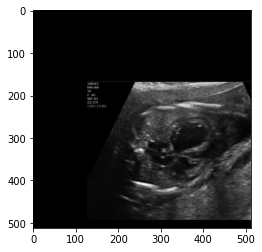

In [47]:
idx = 1
plt.imshow(batch['input'][idx][1, :], cmap='gray')

In [43]:
batch['hm'][0].max()

tensor(1.)

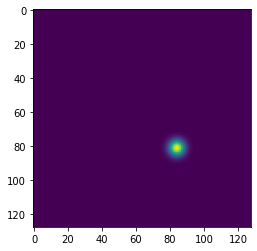

In [48]:
plt.imshow(batch['hm'][idx][1, :])

In [46]:
np.where(batch['hm'][0][1, :] == 1)

(array([58]), array([63]))